In [3]:
import torch
import matplotlib.pyplot as plt
import non_local_boxes
from matplotlib.colors import hsv_to_rgb
import numpy as np
import math
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Sugar coating for reloading
%matplotlib inline
%load_ext autoreload
%autoreload 2

# in ordert to have unblurred pictures
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Line Search & New Collapsing Boxes

### Nonlocal Boxes

In [4]:
matrix_to_tensor = non_local_boxes.utils.matrix_to_tensor
tensor_to_matrix = non_local_boxes.utils.tensor_to_matrix

# Boxes as 2x2x2x2 tensors
PR = matrix_to_tensor(non_local_boxes.utils.PR)
PRprime = matrix_to_tensor(non_local_boxes.utils.PRprime)
SR = matrix_to_tensor(non_local_boxes.utils.SR)
I = matrix_to_tensor(non_local_boxes.utils.I)

m = non_local_boxes.evaluate.nb_columns
W_BS09 = non_local_boxes.utils.W_BS09(m)

def WinCHSH(P): return float(non_local_boxes.evaluate.h_flat(P))                    # P is a 2x2x2x2 tensor
def WinCHSHprime(P): return float(non_local_boxes.evaluate.h_prime_flat(P))         # P is a 2x2x2x2 tensor
phi_flat = non_local_boxes.evaluate.phi_flat
def BoxProduct(W,P,Q): return non_local_boxes.evaluate.R_tensor(W,P,Q)[:,:,:,:,0]
def BoxProduct_matrices(W,P,Q): return tensor_to_matrix(non_local_boxes.evaluate.R(W,P,Q)[:,:,:,:,0]) # Boxes are 4x4 matrices

### Projection of a wiring $\mathsf W$ into the constraint set $\mathcal W$

In [5]:
M1 = torch.zeros(32, 32)
for i in range(32):
    M1[i,i]=1
M1[0,0]=0.5
M1[0,1]=0.5
M1[1,0]=0.5
M1[1,1]=0.5

M2 = torch.zeros(32, 32)
for i in range(32):
    M2[i,i]=1
M2[8,8]=0.5
M2[8,9]=0.5
M2[9,8]=0.5
M2[9,9]=0.5

M3 = torch.zeros(32, 32)
for i in range(32):
    M3[i,i]=1
M3[2,2]=0.5
M3[2,3]=0.5
M3[3,2]=0.5
M3[3,3]=0.5

M4 = torch.zeros(32, 32)
for i in range(32):
    M4[i,i]=1
M4[10,10]=0.5
M4[10,11]=0.5
M4[11,10]=0.5
M4[11,11]=0.5

M5 = torch.zeros(32, 32)
for i in range(32):
    M5[i,i]=1
M5[4,4]=0.5
M5[4,5]=0.5
M5[5,4]=0.5
M5[5,5]=0.5

M6 = torch.zeros(32, 32)
for i in range(32):
    M6[i,i]=1
M6[12,12]=0.5
M6[12,13]=0.5
M6[13,12]=0.5
M6[13,13]=0.5

M7 = torch.zeros(32, 32)
for i in range(32):
    M7[i,i]=1
M7[6,6]=0.5
M7[6,7]=0.5
M7[7,6]=0.5
M7[7,7]=0.5

M8 = torch.zeros(32, 32)
for i in range(32):
    M8[i,i]=1
M8[14,14]=0.5
M8[14,15]=0.5
M8[15,14]=0.5
M8[15,15]=0.5

In [6]:
def projected_wiring(W):  # W is a 32xn tensor
    W = torch.maximum(W, torch.zeros_like(W))  # it outputs the element-wise maximum
    W = torch.minimum(W, torch.ones_like(W))   # similarly for minimum

    T1 = (torch.abs(W[0,:]-W[1,:]) <= torch.abs(W[8, :] - W[9, :]))
    W = T1*torch.tensordot(M1, W, dims=1) + torch.logical_not(T1)*torch.tensordot(M2, W, dims=1)
    
    T2 = (torch.abs(W[2,:]-W[3,:]) <= torch.abs(W[10, :] - W[11, :]))
    W = T2*torch.tensordot(M3, W, dims=1) + torch.logical_not(T2)*torch.tensordot(M4, W, dims=1)

    T3 = (torch.abs(W[4,:]-W[5,:]) <= torch.abs(W[12, :] - W[13, :]))
    W = T3*torch.tensordot(M5, W, dims=1) + torch.logical_not(T3)*torch.tensordot(M6, W, dims=1)

    T4 = (torch.abs(W[6,:]-W[7,:]) <= torch.abs(W[14, :] - W[15, :]))
    W = T4*torch.tensordot(M7, W, dims=1) + torch.logical_not(T4)*torch.tensordot(M8, W, dims=1)

    return W

### Line Search

$$
\left\{
\begin{array}{l}
    \alpha^*_k = \argmax_\alpha \phi(x_k + \alpha \nabla \phi(x_k))\\
    x_{k+1}= \texttt{proj}(x_k + \alpha^*_k \nabla \phi(x_k))
\end{array}
\right.
$$

In [7]:
def reorder_list(L, phi):
    j=0
    while j<len(L):
        if j!=0 and phi[L[j-1]]<phi[L[j]]:
            L[j-1],L[j]=L[j],L[j-1]
            j-=2
        j+=1
    return L

In [8]:
def select_best_columns(W, P, Q, integer):
    # P,Q are 4x4 matrices
    if integer==0: return non_local_boxes.utils.random_wiring(m).detach()
    # L is the list of the "best" indexes of the columns of W
    # At the begining, we take the first indexes of W
    # We will change the list L by comparing the value at the other indexes
    # When we add a term to L, we also remove the "worst" one, and we re-order the list L
    L = [*range(integer)]
    # phi is the list of values:
    phi= phi_flat(W,P,Q).tolist()
    # we re-order the list L:
    L = reorder_list(L, phi)
    for i in range(integer, m):
        if phi[i]>phi[L[-1]]:
            L[-1]=i # we remove and replace the worst index
            L = reorder_list(L, phi)

    W_new = non_local_boxes.utils.random_wiring(m).detach()
    for k in range(integer):
        W_new[:,k] = W[:,L[k]] # we keep only the best ones

    return W_new

In [9]:
def line_search_with_resets(P, Q, LS_iterations, K_reset, chi):
    # P,Q are 4x4 matrices
    W, external_grad = torch.zeros(32,m), torch.ones(m)
    Krange, LSrange = range(K_reset), range(LS_iterations)
    
    for j in range(0,int(1/chi)):
        # Reset some of the wirings:
        W = select_best_columns(W, P, Q, min(m, int(j*m*chi))).detach()
        W.requires_grad=True

        # At the end, we do a lot of steps:
        if j==int(1/chi)-1:  Krange=range(10*K_reset)

        # Line search:
        for _ in Krange:
            phi_flat(W, P, Q).backward(gradient=external_grad)
            gradient=W.grad
            alpha = torch.ones(m)*0.01
            Gains = phi_flat(W, P, Q)
            Gains_futur = phi_flat(W + alpha*gradient, P, Q)
            for _ in LSrange:
                mask = 0.0 + (Gains>Gains_futur)
                alpha = 0.8*mask*alpha + 1.3*(1-mask)*alpha
                Gains = torch.max(Gains, Gains_futur)
                Gains_futur = phi_flat(W + alpha*gradient, P, Q)
            W = projected_wiring(W + alpha*gradient).detach()
            W.requires_grad=True

    return W

### Draw the new collapsing boxes

In [10]:
def Compute_Coeff(P1, P2, P3, G_value, CHSH_value, WinGame):
    A = np.array([[WinGame(P1), WinGame(P2), WinGame(P3)],
                  [WinCHSH(P1), WinCHSH(P2), WinCHSH(P3)],
                  [1, 1, 1]])
    b = np.array([G_value, CHSH_value, 1])
    return np.linalg.solve(A,b).tolist()

def E(Box, x, y):
    return Box[0,0,x,y] + Box[1,1,x,y] - Box[0,1,x,y] - Box[1,0,x,y]

def is_in_Q(G_value,CHSH_value, Box1, Box2, Box3, WinGame):
    alpha, beta, gamma = Compute_Coeff(Box1, Box2, Box3, G_value, CHSH_value, WinGame)
    Box = alpha*Box1 + beta*Box2 + gamma*Box3
        # Box is a 2x2x2x2 tensor
    coeff00 = np.arcsin(E(Box,0,0))
    coeff01 = np.arcsin(E(Box,0,1))
    coeff10 = np.arcsin(E(Box,1,0))
    coeff11 = np.arcsin(E(Box,1,1))
    return coeff00 + coeff01 + coeff10 - coeff11 <= np.pi

In [11]:
def eta(P, x, y):
    return 2*P[0,x*y,x,y] + 2*P[1,(1+x*y)%2,x,y] - 1

def is_in_BBP23(G_value,CHSH_value, Box1, Box2, Box3, WinGame):
    alpha, beta, gamma = Compute_Coeff(Box1, Box2, Box3, G_value, CHSH_value, WinGame)
    P = alpha*Box1 + beta*Box2 + gamma*Box3
        # Box is a 2x2x2x2 tensor
    A = (eta(P,0,0)+eta(P,0,1)+eta(P,1,0)+eta(P,1,1))**2
    B = 2*eta(P,0,0)**2+4*eta(P, 1,0)*eta(P,0,1) + 2*eta(P, 1,1)**2
    return A+B>16

In [12]:
def is_in_BS09(P, max_power):
    if WinCHSH(P)>(3+math.sqrt(6))/6: return True
    W = non_local_boxes.utils.W_BS09(non_local_boxes.evaluate.nb_columns)
    for _ in range(max_power):
        P = BoxProduct(W, P, P)
        if WinCHSH(P)>(3+math.sqrt(6))/6: return True
    return False

In [13]:
def is_in_here(P, max_power, LS_iterations, K_reset, chi):
    # cf. "Algorithm 4" in the article
    # Here we turn the 2x2x2x2 tensors into 4x4 matrices
    P = tensor_to_matrix(P)
    Pn = P
    for _ in range(max_power):
        print("Win CHSH(Pn) = ", WinCHSH(matrix_to_tensor(Pn)))
        W = line_search_with_resets(Pn, P, LS_iterations, K_reset, chi).detach()
        L = phi_flat(W,Pn,P)
        print("max =", float(torch.max(L)), "mean=", float(torch.mean(L)), "min", float(torch.min(L)))
        W = select_best_columns(W, Pn, P, 1)
        L = phi_flat(W,Pn,P)
        print("max =", float(torch.max(L)), "mean=", float(torch.mean(L)), "min", float(torch.min(L)))
        Pn = BoxProduct_matrices(W, Pn, P).detach()
        if WinCHSH(matrix_to_tensor(Pn))>(3+math.sqrt(6))/6:   return True
    return False

In [14]:
# P = (PR/2 + SR/2)
# is_in_here(P, max_power=5, LS_iterations=20, K_reset=30, chi=0.1)

In [15]:
def draw_collapsing_boxes(P1, P1name, P2, P2name, P3, P3name, WinGame, max_power, LS_iterations, K_reset, chi, precision=0.001, precisionQ=1e-4, markersize=4):
    # P, P1, P2, P3 are 2x2x2x2 matrices

    # Draw the initial background triangle:
    x1, y1 = WinGame(P1), WinCHSH(P1)
    x2, y2 = WinGame(P2), WinCHSH(P2)
    x3, y3 = WinGame(P3), WinCHSH(P3)

    # Check if our coordinate system is good, i.e. if projected points aren't aligned:
    if (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3):
            print("\n    WARNING: Error in the coordinate system.")
            return None
    
    # Colors:
    BBLMTU_color = hsv_to_rgb([0.475, 1, 0.5])
    #BS09_color = hsv_to_rgb([0.870, 0.7, 0.7])
    BS09_color = hsv_to_rgb([0.51, 1, 0.7])
    BBP23_color = hsv_to_rgb([0.575, 0.7, 0.7])
    here_color = hsv_to_rgb([1/14, 1, 1])
    NS_color = hsv_to_rgb([0.475, 1, 0.9])
    Quantum_color = 'pink'

    triangle = plt.Polygon(np.array([[x1, y1], [x2,y2], [x3, y3]]), color=NS_color)
    plt.gca().add_patch(triangle)

    # Draw the Quantum area:
    G_value=min(x2,x3)
    CHSH_value=(2+np.sqrt(2))/4
    while G_value<=max(x2, x3):
        if is_in_Q(G_value, CHSH_value, P1, P2, P3, WinGame):
            plt.plot([G_value, G_value], [CHSH_value, y2], color=Quantum_color)
            G_value+=precisionQ
        else:
            CHSH_value= max(CHSH_value-precisionQ, y2)
    plt.plot(0.75, 0.75,'o', markersize=0.7, color=Quantum_color)

    # Draw the collapsing area [BBLMTU06]:
    BBLMTU_value = (3+math.sqrt(6))/6
    x2_BBLMTU = x1+(x2-x1)*(1-BBLMTU_value)/(1-y2)  
    x3_BBLMTU = x1 - (x1-x3)*(1-BBLMTU_value)/(1-y3)
    BBLMTU_rectangle = plt.Polygon(np.array([[x1, y1], [x2_BBLMTU,BBLMTU_value], [x3_BBLMTU, BBLMTU_value]]), color=BBLMTU_color) # use Thales theorem
    plt.gca().add_patch(BBLMTU_rectangle)

    # Draw the collapsing area [BBP23]:
    G_value = min(x2,x3)
    CHSH_value = 0.9
    while G_value+CHSH_value<=1.5:
        if is_in_BBP23(G_value, CHSH_value, P1, P2, P3, WinGame):
            plt.plot([G_value, G_value], [CHSH_value, min(BBLMTU_value,1.5-G_value)], color=BBP23_color)
            G_value+=precisionQ
            CHSH_value = 0.75*(G_value-0.5)/(0.75-0.5) + 0.9*(G_value-0.75)/(0.5-0.75) # Lagrange interpolation
        else:
            if CHSH_value+precisionQ < BBLMTU_value: CHSH_value= min(CHSH_value+precisionQ, BBLMTU_value)
            else: 
                G_value+=precisionQ
                CHSH_value = 0.75*(G_value-0.5)/(0.75-0.5) + 0.9*(G_value-0.75)/(0.5-0.75) # Lagrange interpolation
    
    # Draw the collapsing boxes [BS09]:
    List_BS09 = []
    alpha_max = 1-(1-BBLMTU_value)/(y1-y3)
    alpha, gamma = 0., 0.
    while gamma<0.5 and alpha<alpha_max:
        P = alpha*PR + (1-alpha-gamma)*SR + gamma*(I+PR)/2
        if is_in_BS09(P, max_power):
            List_BS09.append(np.around([alpha, gamma], decimals=4).tolist())
            alpha2 = alpha
            while alpha2<alpha_max:
                P = alpha2*PR + (1-alpha2-gamma)*SR + gamma*(I+PR)/2
                plt.plot(WinGame(P), WinCHSH(P), 'o', markersize=markersize, color=BS09_color)
                alpha2= round(alpha2+precision, 4)
            gamma+=precision*(3/4)
        else: alpha+=precision
            
    # Draw the collapsing boxes [here]:
    List_here=[]
    alpha_max = 1-(1-BBLMTU_value)/(y1-y3)
    alpha, gamma = 0., 0.
    while gamma<0.5 and alpha<alpha_max:
        alpha2, gamma2 = np.around([alpha, gamma], decimals=4).tolist()
        print(alpha2, gamma2)
        if [alpha2, gamma2] in List_BS09:   gamma+=precision*(3/4)
        else:
            P = alpha2*PR + (1-alpha2-gamma2)*SR + gamma2*(I+PR)/2
            if is_in_here(P, max_power, LS_iterations, K_reset, chi):
                List_here.append([alpha2,gamma2])
                while alpha2<alpha_max and [alpha2,gamma2] not in List_BS09:
                    P = alpha2*PR + (1-alpha2-gamma2)*SR + gamma2*(I+PR)/2
                    plt.plot(WinGame(P), WinCHSH(P), 'o', markersize=markersize, color=here_color)
                    alpha2= round(alpha2+precision, 4)
                gamma+=precision*(3/4)
            else: alpha+=precision

    # Pyplot settings:
    plt.text(x1+0.001, y1, P1name, horizontalalignment='center',weight="bold")
    plt.text(x2, y2-0.007, P2name, verticalalignment='center',weight="bold")
    plt.text(x3, y3-0.007, P3name, verticalalignment='center',weight="bold")
    plt.title("Collapsing Boxes ($K_{reset}$="+str(K_reset)+", χ="+str(chi)+", m=10^"+str(int(np.log10(m)))+", M="+str(LS_iterations)+", N="+str(max_power)+").")
    plt.xlabel("$\mathbb{P}($win at CHSH'$)$")
    plt.ylabel("$\mathbb{P}($win at CHSH$)$")
    handles = []
    handles.append( mpatches.Patch(color=BBLMTU_color, label='Collapsing $\mathcal{N\!S}$-boxes from [BBLMTU06].') )
    handles.append( mlines.Line2D([], [],color=BS09_color, marker='o',ls='', label="Collapsig $\mathcal{N\!S}$-boxes from [BS09].") )
    handles.append( mpatches.Patch(color=BBP23_color, label='Collapsing $\mathcal{N\!S}$-boxes from [BBP23].') )
    handles.append( mlines.Line2D([], [],color=here_color, marker='o',ls='', label="New collapsig $\mathcal{N\!S}$-boxes [EWC22],[here].") )
    handles.append( mpatches.Patch(color=NS_color, label='Other $\mathcal{N\!S}$-boxes.') )
    handles.append( mpatches.Patch(color=Quantum_color, label='Quantum boxes.') )
    plt.legend(handles=handles, fontsize = 9)   #  , loc='upper left'
    #plt.xlim(min(x1, x2, x3), max(x1, x2, x3))
    #plt.ylim(min(y1, y2, y3), max(y1, y2, y3))
    ax=plt.gca()
    ax.relim(), ax.autoscale_view()   # auto-scale axes
    plt.show()

    return List_BS09, List_here, precision

# Compute from skratch

In [16]:
# draw_collapsing_boxes(
#     P1 = PR,       P1name = "PR",
#     P2 = SR,       P2name = "SR",
#     P3 = (I+PR)/2, P3name = "(I+PR)/2",
#     WinGame=WinCHSHprime,
#     max_power= 5,
#     LS_iterations = 20, 
#     K_reset = 10, 
#     chi = 0.1,
#     precision=1.5e-2,   # 1.5e-2
#     precisionQ=1e-4,  # 1e-4
#     markersize=2      #2
#     )

# Draw using previous lists

(Nice to change the text on the drawing and to change the colors.)

In [69]:
def draw_from_lists(P1, P1name, P2, P2name, P3, P3name, WinGame, List_BS09, List_here, max_power, LS_iterations, K_reset, chi, precision=0.001, precisionQ=1e-4, markersize=4, big=True):
    # P, P1, P2, P3 are 2x2x2x2 matrices

    # Draw the initial background triangle:
    x1, y1 = WinGame(P1), WinCHSH(P1)
    x2, y2 = WinGame(P2), WinCHSH(P2)
    x3, y3 = WinGame(P3), WinCHSH(P3)

    # Check if our coordinate system is good, i.e. if projected points aren't aligned:
    if (x1 - x3)*(y2-y3)==(x2-x3)*(y1-y3):
            print("\n    WARNING: Error in the coordinate system.")
            return None
    
    # Colors:
    BBLMTU_color = hsv_to_rgb([0.475, 1, 0.5])
    #BS09_color = hsv_to_rgb([0.870, 0.7, 0.7])
    BS09_color = hsv_to_rgb([0.51, 1, 0.7])
    BBP23_color = hsv_to_rgb([0.575, 1, 0.6])
    here_color = hsv_to_rgb([1/14, 1, 1])
    NS_color = hsv_to_rgb([0.475, 1, 0.9])
    Quantum_color = 'pink'

    triangle = plt.Polygon(np.array([[x1, y1], [x2,y2], [x3, y3]]), color=NS_color)
    plt.gca().add_patch(triangle)

    # Draw the Quantum area:
    G_value=min(x2,x3)
    CHSH_value=(2+np.sqrt(2))/4
    while G_value<=max(x2, x3):
        if is_in_Q(G_value, CHSH_value, P1, P2, P3, WinGame):
            plt.plot([G_value, G_value], [CHSH_value, y2], color=Quantum_color)
            G_value+=precisionQ
        else:
            CHSH_value= max(CHSH_value-precisionQ, y2)
    plt.plot(0.75, 0.75,'o', markersize=0.7, color=Quantum_color)

    # Draw the collapsing area [BBLMTU06]:
    BBLMTU_value = (3+math.sqrt(6))/6
    x2_BBLMTU = x1+(x2-x1)*(1-BBLMTU_value)/(1-y2)  
    x3_BBLMTU = x1 - (x1-x3)*(1-BBLMTU_value)/(1-y3)
    BBLMTU_rectangle = plt.Polygon(np.array([[x1, y1], [x2_BBLMTU,BBLMTU_value], [x3_BBLMTU, BBLMTU_value]]), color=BBLMTU_color) # use Thales theorem
    plt.gca().add_patch(BBLMTU_rectangle)

    # Draw the collapsing area [BBP23]:
    G_value = min(x2,x3)
    CHSH_value = 0.9
    while G_value+CHSH_value<=1.5:
        if is_in_BBP23(G_value, CHSH_value, P1, P2, P3, WinGame):
            plt.plot([G_value, G_value], [CHSH_value, min(BBLMTU_value,1.5-G_value)], color=BBP23_color)
            G_value+=precisionQ
            CHSH_value = 0.75*(G_value-0.5)/(0.75-0.5) + 0.9*(G_value-0.75)/(0.5-0.75) # Lagrange interpolation
        else:
            if CHSH_value+precisionQ < BBLMTU_value: CHSH_value= min(CHSH_value+precisionQ, BBLMTU_value)
            else: 
                G_value+=precisionQ
                CHSH_value = 0.75*(G_value-0.5)/(0.75-0.5) + 0.9*(G_value-0.75)/(0.5-0.75) # Lagrange interpolation
    plt.plot([x2_BBLMTU, x3_BBLMTU], [BBLMTU_value, BBLMTU_value], linewidth=1.7, color=BBP23_color)

    # Draw the collapsing boxes [BS09]:
    alpha_max = 1-(1-BBLMTU_value)/(y1-y3)
    for [alpha, gamma] in List_BS09:
        alpha2 = alpha
        while alpha2<alpha_max:
            P = alpha2*PR + (1-alpha2-gamma)*SR + gamma*(I+PR)/2
            plt.plot(WinGame(P), WinCHSH(P), 'o', markersize=markersize, color=BS09_color)
            alpha2+=precision
            
    # Draw the collapsing boxes [here]:
    for [alpha, gamma] in List_here:
        alpha2 = alpha
        while alpha2<alpha_max and [alpha2,gamma] not in List_BS09:
            P = alpha2*PR + (1-alpha2-gamma)*SR + gamma*(I+PR)/2
            plt.plot(WinGame(P), WinCHSH(P), 'o', markersize=markersize, color=here_color)
            alpha2= round(alpha2+precision, 4)

    # Pyplot settings:
    plt.text(x1+0.001, y1, P1name, horizontalalignment='center',weight="bold")
    plt.text(x2, y2-0.007, P2name, verticalalignment='center',weight="bold")
    plt.text(x3, y3-0.007, P3name, verticalalignment='center',weight="bold")
    if big:  fontsize=15
    else:    fontsize=12.5
    plt.title(f"""Collapsing Boxes ($K_{{reset}}$={K_reset}, χ={chi}, m=$10^{int(np.log10(m))}$, M={LS_iterations}, N={max_power}).""",
              fontsize=fontsize)
    #plt.title("Collapsing Boxes ($K_{reset}$="+str(K_reset)+", χ="+str(chi)+string+str(LS_iterations)+", N="+str(max_power)+").")
    if big:  fontsize=12
    else:    fontsize=10
    plt.xlabel("$\mathbb{P}($win at $\mathbf{CHSH}')$", fontsize=fontsize)
    plt.ylabel("$\mathbb{P}($win at $\mathbf{CHSH})$", fontsize=fontsize)
    handles = []
    handles.append( mpatches.Patch(color=BBLMTU_color, 
        label='Collapsing $\mathcal{N\!S}$-boxes\nfrom [BBLMTU06].') )
    handles.append( mlines.Line2D([], [],color=BS09_color, marker='o',ls='', 
        label="Collapsing $\mathcal{N\!S}$-boxes\nfrom [BS09].") )
    handles.append( mpatches.Patch(color=BBP23_color, 
        label='Collapsing $\mathcal{N\!S}$-boxes\nfrom [BBP23].') )
    handles.append( mlines.Line2D([], [],color=here_color, marker='o',ls='', 
        label="Collapsing $\mathcal{N\!S}$-boxes\nusing Algorithm 4.") )
    handles.append( mpatches.Patch(color=NS_color, label='Other $\mathcal{N\!S}$-boxes.') )
    handles.append( mpatches.Patch(color=Quantum_color, label='Quantum boxes.') )
    if big:  fontsize=10.5
    else:    fontsize=9.5
    plt.legend(handles=handles, fontsize = fontsize, loc='upper right')  
    #plt.xlim(min(x1, x2, x3), max(x1, x2, x3))
    #plt.ylim(min(y1, y2, y3), max(y1, y2, y3))
    ax=plt.gca()
    ax.relim(), ax.autoscale_view()   # auto-scale axes
    plt.show()

/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_19862/3522625127.py:15: RuntimeWarning: invalid value encountered in arcsin
  coeff00 = np.arcsin(E(Box,0,0))
/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_19862/3522625127.py:16: RuntimeWarning: invalid value encountered in arcsin
  coeff01 = np.arcsin(E(Box,0,1))
/var/folders/12/4s0kzhwj609b8wfg_zj3xl080000gn/T/ipykernel_19862/3522625127.py:17: RuntimeWarning: invalid value encountered in arcsin
  coeff10 = np.arcsin(E(Box,1,0))


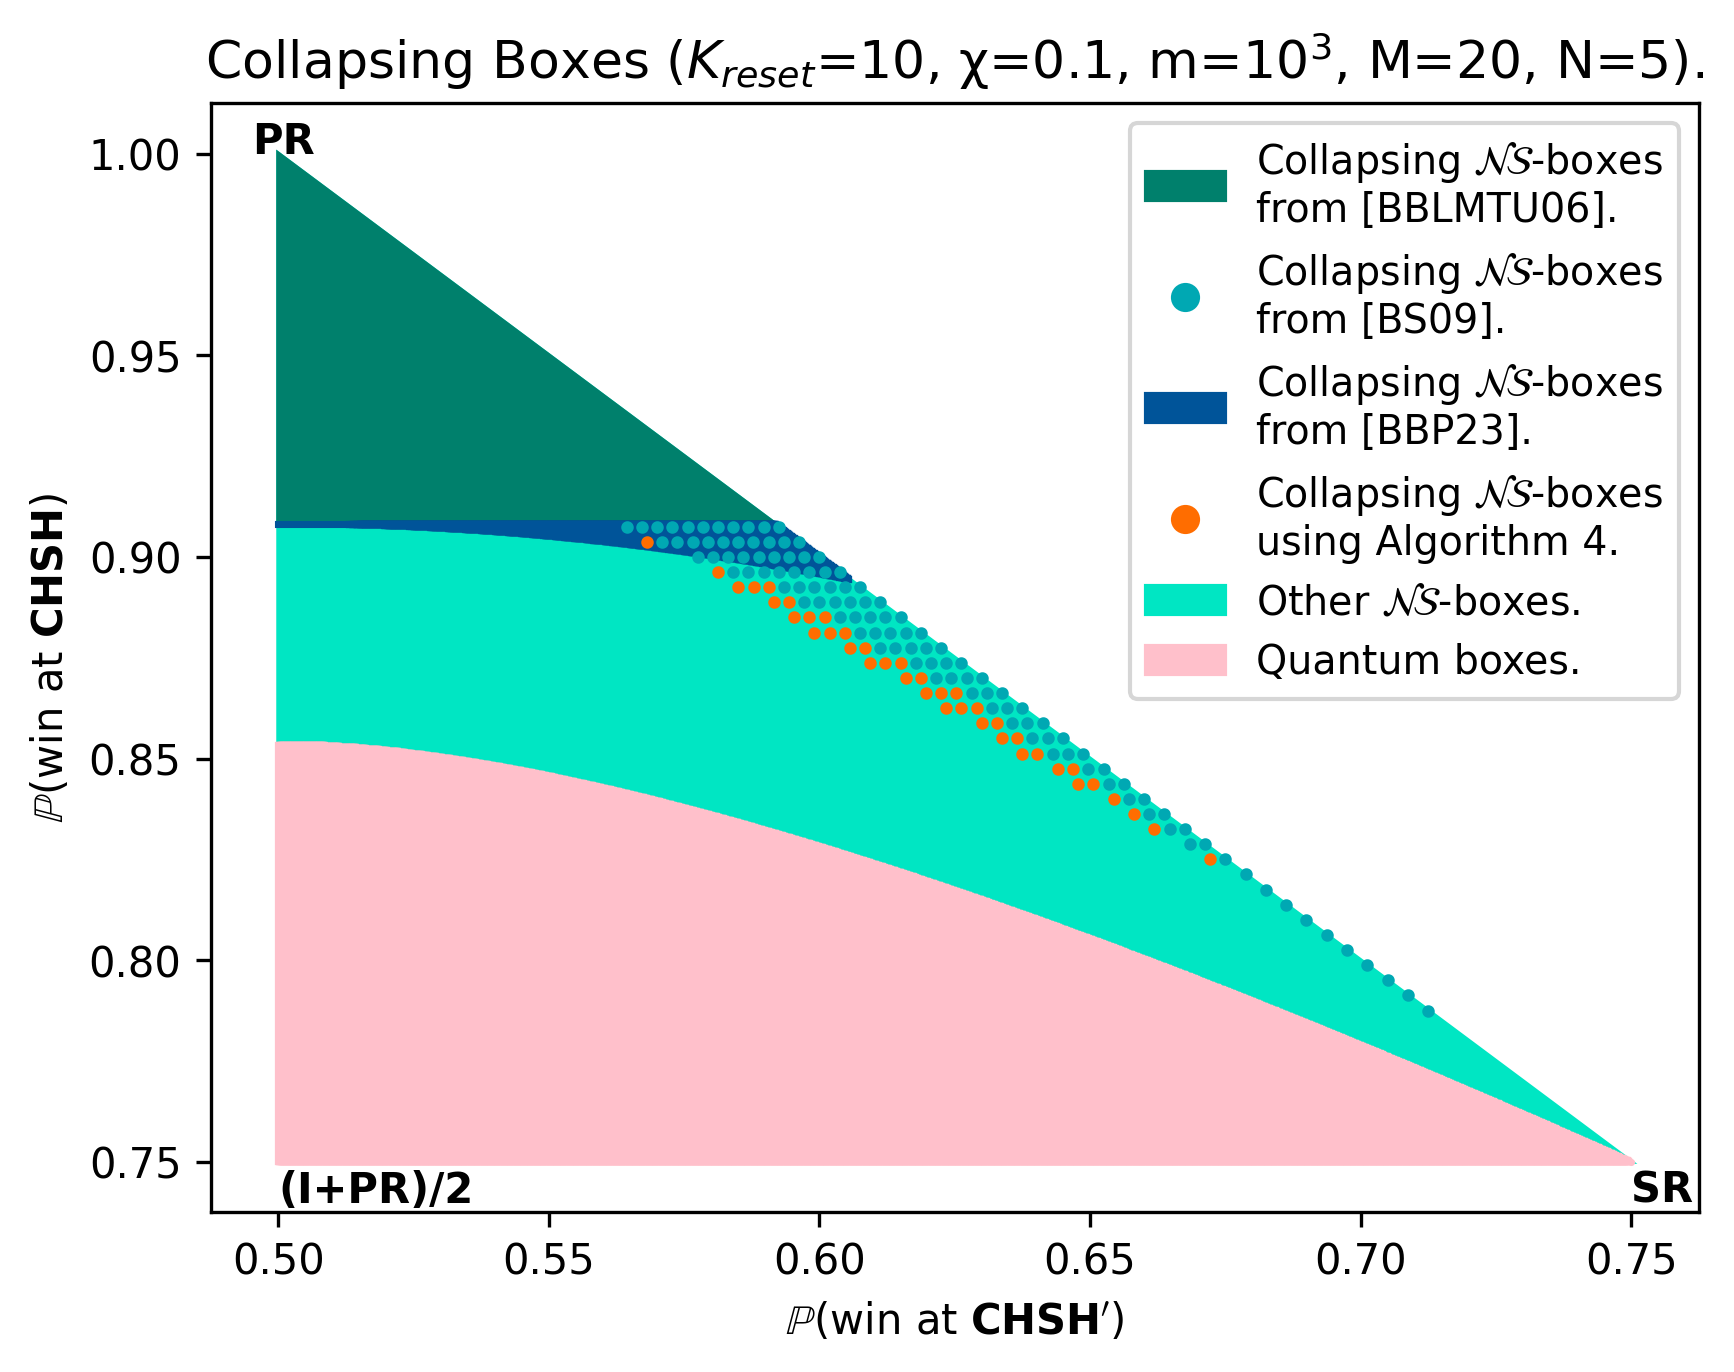

In [71]:
#List_BS09, List_here = ([[0.2, 0.0], [0.6, 0.075]], [])

List_BS09, List_here, precision = (
 [[0.15, 0.0],
  [0.315, 0.0112],
  [0.405, 0.0225],
  [0.48, 0.0338],
  [0.51, 0.045],
  [0.555, 0.0562],
  [0.585, 0.0675],
  [0.585, 0.0787],
  [0.6, 0.09],
  [0.615, 0.1012],
  [0.63, 0.1125]],
 [[0.3, 0.0112],
  [0.33, 0.0225],
  [0.375, 0.0338],
  [0.405, 0.045],
  [0.45, 0.0562],
  [0.495, 0.0675],
  [0.525, 0.0787],
  [0.57, 0.09],
  [0.615, 0.1012],
  [0.615, 0.1125],
  #[0.63, 0.1232]
  ],
 0.015)

m=int(1e3)

draw_from_lists(
    P1 = PR,       P1name = "PR",
    P2 = SR,       P2name = "SR",
    P3 = (I+PR)/2, P3name = "(I+PR)/2",
    WinGame=WinCHSHprime,
    List_BS09=List_BS09,
    List_here=List_here,
    max_power= 5,
    LS_iterations = 20, 
    K_reset = 10, 
    chi = 0.1,
    precision=precision,   # 1.5e-2
    precisionQ=1e-4,  # 1e-4
    markersize=2,      #2
    big=False
)